# Training the Image classifier

### What this notebook will cover

- Set up the dataloaders
- Crop the input images
- Perform the data augmentation
- Train a Resnext101 image classifier model
- Extract the Global Average Pool layer (GAP), i.e. embedding, for each image from the classifier model
- Link to pre-calculated embeddings from 2 place solution


### Messy start, skip ahead
Note the initial few cells here are a little messy as I have just done a quick port over the 2nd place solution python package. To get to the meat of this notebook you can skip down a few cells to where things get interesting

### Core training parameters
- Image size set to (408,408) for my GPU
    - the original solution used (512, 512) but I couldn't get a reasonable batch size on my gpu at that size
- batch size = 18
- 5 epochs
- lr = 2e-5
- Optimizer : Adam
- Folds = 0
    - This notebook doesn't use any cross validation for the sake of time, however the original solution used 5-fold validation, training on 3 of the folds

# Imports and Settings - Not so interesting

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import optparse
import os, sys
import numpy as np 
import pandas as pd
from PIL import Image
import torch
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold

import os
import cv2
import glob
import numpy as np
import pandas as pd
import torch.optim as optim

from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
from sklearn.metrics import log_loss
from torch.utils.data import DataLoader

import cv2
import gc
import random
import logging
import datetime

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms as T
from torchvision.models.resnet import ResNet, Bottleneck
from torch.hub import load_state_dict_from_url
from torchvision.models.resnet import ResNet, Bottleneck

from albumentations import (Cutout, Compose, Normalize, RandomRotate90, HorizontalFlip,
                           VerticalFlip, ShiftScaleRotate, Transpose, OneOf, IAAAdditiveGaussianNoise,
                           GaussNoise, RandomGamma, RandomContrast, RandomBrightness, HueSaturationValue,
                           RandomBrightnessContrast, Lambda, NoOp, CenterCrop, Resize
                           )

from tqdm import tqdm

from random import sample 

from scripts.logs import get_logger
from scripts.utils import dumpobj, loadobj, GradualWarmupScheduler

from apex import amp
from apex.parallel import DistributedDataParallel as DDP
from apex.fp16_utils import *
from apex import amp, optimizers
from apex.multi_tensor_apply import multi_tensor_applier

import warnings
warnings.filterwarnings('ignore')

### Keep Scrolling...

In [2]:
# Print info about environments
parser = optparse.OptionParser()
parser.add_option('-s', '--seed', action="store", dest="seed", help="model seed", default="1234")
parser.add_option('-o', '--fold', action="store", dest="fold", help="Fold for split", default="0")
parser.add_option('-p', '--nbags', action="store", dest="nbags", help="Number of bags for averaging", default="0")
parser.add_option('-e', '--epochs', action="store", dest="epochs", help="epochs", default="5")
parser.add_option('-j', '--start', action="store", dest="start", help="Start epochs", default="0")
parser.add_option('-b', '--batchsize', action="store", dest="batchsize", help="batch size", default="16")
parser.add_option('-r', '--rootpath', action="store", dest="rootpath", help="root directory", default="")
parser.add_option('-i', '--imgpath', action="store", dest="imgpath", help="root directory", default="data/512X512X6/")
parser.add_option('-w', '--workpath', action="store", dest="workpath", help="Working path", default="weights/")
parser.add_option('-f', '--weightsname', action="store", dest="weightsname", help="Weights file name", default="pytorch_model.bin")
parser.add_option('-l', '--lr', action="store", dest="lr", help="learning rate", default="0.00005")
parser.add_option('-g', '--logmsg', action="store", dest="logmsg", help="root directory", default="Recursion-pytorch")
parser.add_option('-c', '--size', action="store", dest="size", help="model size", default="512")
parser.add_option('-a', '--infer', action="store", dest="infer", help="root directory", default="TRN")
parser.add_option('-z', '--wtsize', action="store", dest="wtsize", help="model size", default="999")
parser.add_option('-m', '--hflip', action="store", dest="hflip", help="Augmentation - Embedding horizontal flip", default="F")
parser.add_option('-d', '--transpose', action="store", dest="transpose", help="Augmentation - Embedding transpose", default="F")
parser.add_option('-x', '--stage2', action="store", dest="stage2", help="Stage2 embeddings only", default="F")
parser.add_option('-y', '--autocrop', action="store", dest="autocrop", help="Autocrop", default="T")

options, args = parser.parse_args()
package_dir = options.rootpath
sys.path.append(package_dir)
sys.path.insert(0, 'scripts')

### Keep Scrolling...

In [3]:
### FROM OPTIONS ABOVE ###
N_GPU=1
WDIR='resnext101v01'
FOLD=0
SIZE=408

start = 0
epochs = 5
fold = f'{FOLD}'
lr = 0.00002
batchsize = 18
workpath = 'scripts/resnext101v01'
imgpath = 'data/rsna_darraghdog/darraghdog_proc'
size = f'{SIZE}' 
weightsname = f'weights/model_512_resnext101{FOLD}.bin'
autocrop = 'T'

logmsg = f'Rsna-lb-{SIZE}-fp16'
#######

logger = get_logger(logmsg, 'INFO') # noqa
logger.info('Cuda set up : time {}'.format(datetime.datetime.now().time()))

device=torch.device('cuda')

logger.info('Device : {}'.format(torch.cuda.get_device_name(0)))
logger.info('Cuda available : {}'.format(torch.cuda.is_available()))

n_gpu = torch.cuda.device_count()

logger.info('Cuda n_gpus : {}'.format(n_gpu ))
    
SEED = int(options.seed)
#SIZE = int(options.size)
WTSIZE=int(options.wtsize) if int(options.wtsize) != 999 else SIZE
EPOCHS = epochs #int(options.epochs)
START = start #int(options.start)
AUTOCROP=options.autocrop=='T'
n_epochs = epochs #EPOCHS 
lr=float(lr)
batch_size = int(batchsize)
ROOT = options.rootpath
path_data = 'data/rsna_darraghdog'  #os.path.join(ROOT, 'data/rsna_darraghdog')
path_img = imgpath  #os.path.join(ROOT, options.imgpath)
WORK_DIR = os.path.join(ROOT, options.workpath)
WEIGHTS_NAME = options.weightsname
fold = FOLD #int(options.fold)
INFER=options.infer
HFLIP = 'T' if options.hflip=='T' else ''
TRANSPOSE = 'P' if options.transpose=='T' else ''
STAGE2=options.stage2=='T'

device = 'cuda'

logger.info('Load params : time {}'.format(datetime.datetime.now().time()))
for (k,v) in options.__dict__.items():
    logger.info('{}{}'.format(k.ljust(20), v))

print('Data path : {}'.format(path_data))
print('Image path : {}'.format(path_img))

os.environ["TORCH_HOME"] = os.path.join( path_data, 'mount')
logger.info(os.system('$TORCH_HOME'))

2020-01-29 13:19:45,336 - Rsna-lb-408-fp16 - INFO - Cuda set up : time 13:19:45.336528
2020-01-29 13:19:45,360 - Rsna-lb-408-fp16 - INFO - Device : GeForce RTX 2080 Ti
2020-01-29 13:19:45,361 - Rsna-lb-408-fp16 - INFO - Cuda available : True
2020-01-29 13:19:45,362 - Rsna-lb-408-fp16 - INFO - Cuda n_gpus : 1
2020-01-29 13:19:45,363 - Rsna-lb-408-fp16 - INFO - Load params : time 13:19:45.363760
2020-01-29 13:19:45,364 - Rsna-lb-408-fp16 - INFO - seed                1234
2020-01-29 13:19:45,365 - Rsna-lb-408-fp16 - INFO - fold                0
2020-01-29 13:19:45,365 - Rsna-lb-408-fp16 - INFO - nbags               0
2020-01-29 13:19:45,366 - Rsna-lb-408-fp16 - INFO - epochs              5
2020-01-29 13:19:45,366 - Rsna-lb-408-fp16 - INFO - start               0
2020-01-29 13:19:45,367 - Rsna-lb-408-fp16 - INFO - batchsize           16
2020-01-29 13:19:45,368 - Rsna-lb-408-fp16 - INFO - rootpath            
2020-01-29 13:19:45,368 - Rsna-lb-408-fp16 - INFO - imgpath             data/512X5

Data path : data/rsna_darraghdog
Image path : data/rsna_darraghdog/darraghdog_proc


In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if n_gpu > 0:
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
    
logger.info('Load Dataframes')
dir_train_img = os.path.join(path_data, 'darraghdog_proc/')
dir_test_img = os.path.join(path_data, 'darraghdog_proc/')

# Parameters
n_classes = 6
label_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

2020-01-29 13:19:45,404 - Rsna-lb-408-fp16 - INFO - Load Dataframes


# Interesting

### autocrop
In the winner's words it cuts *"any black space back to edges of where non-black space begins; although keep the square aspect ratio*

It is used to remove from the images any parts of bed or machine surrounding the patient's head

I would highly recommend checking out the fastai notebook here which has a really nice masking function to crop out any unwanted artifcats: https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai

In [5]:
def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold
    Returns square, cropped image.
    https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv
    """

    if len(image.shape) == 3:
        # Takes just 1 channel (the last one)
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    
    # EXPLAINER:
    # - np.max(flatImage, 0)
    #     For each of the 512 rows in the image, find the max value for each one
    #
    # - np.where(np.max(flatImage, 0) > threshold) :
    #     Find the rows indices where the max value is greater than the threshold (zero in this case)
    #     i.e. value isn't black
    
    # Returns the row indices where the max value is greater than zero (i.e. not black)
    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    cols = np.where(np.max(flatImage, 1) > threshold)[0]
    
    # Crop image to the first and last rows and columns that are non-zero
    # e.g. image[79 : 346 + 1, 43 : 443]
    image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]   # image.shape now = (357, 399, 3)
    
    #logger.info(image.shape)
    sqside = max(image.shape)   # e.g. 399
    
    # Create new 3-channel square black image with, for example, dimension (512,512,3)
    imageout = np.zeros((sqside, sqside, 3), dtype = 'uint8')
    
    # Copy pixels from cropped image into the new image
    imageout[:image.shape[0], :image.shape[1],:] = image.copy()   # imageout.shape = (399,399,3)
    return imageout

### Lets have a look at what `autocrop` does

(399, 399, 3)


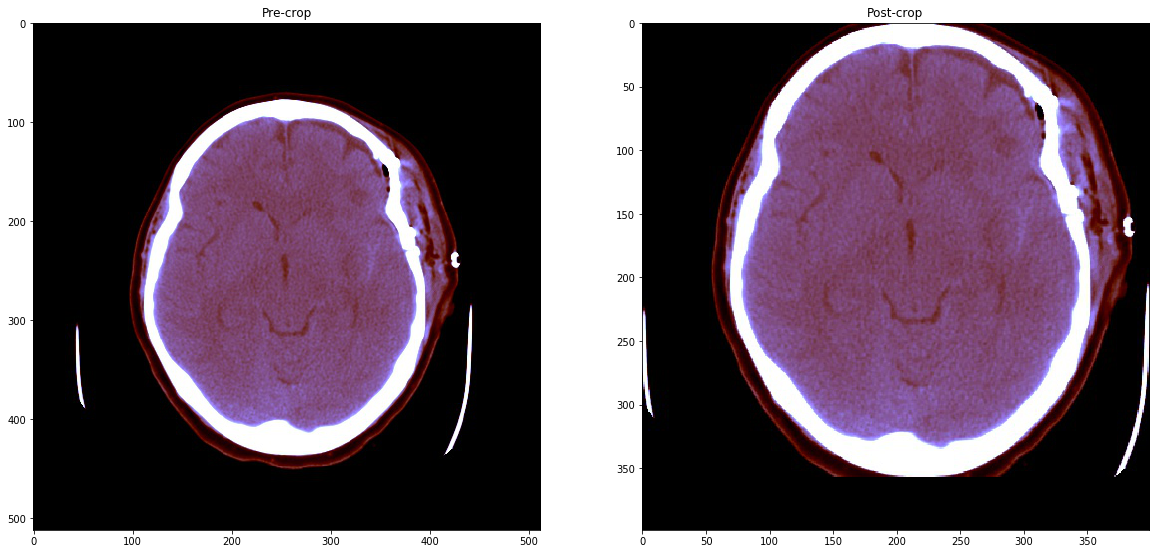

In [13]:
nm = 'data/rsna_darraghdog/darraghdog_proc/train_ID_aec8e68b3.jpg'

im = Image.open(nm)
np_im = np.array(im)

imageout = autocrop(np_im, threshold = 250)
im_ls = [im, imageout]

titles = ['Pre-crop', 'Post-crop']
f, axarr = plt.subplots(1,2, figsize=(20, 10))
for i in range(2):
    axarr[i].imshow(im_ls[i], cmap='gray')
    axarr[i].set_title(titles[i])

### Bonus!
- `autocropmin` is a function that the 2nd place team coded up, but in the heat of competition forgot to add to their training script.
- It should remove most artifacts around images such as the curved lines above from the scanning machine
- I would still recommend checkout out what the fastai2 library can do for masking insread of using this

In [14]:
import scipy.ndimage as ndimage

def autocropmin(image, threshold=0, kernsel_size = 10):
        
    img = image.copy()
    SIZE = img.shape[0]
    imgfilt = ndimage.minimum_filter(img.max((2)), size=kernsel_size)
    rows = np.where(np.max(imgfilt, 0) > threshold)[0]
    cols = np.where(np.max(imgfilt, 1) > threshold)[0]
    row1, row2 = rows[0], rows[-1] + 1
    col1, col2 = cols[0], cols[-1] + 1
    row1, col1 = max(0, row1-kernsel_size), max(0, col1-kernsel_size)
    row2, col2 = min(SIZE, row2+kernsel_size), min(SIZE, col2+kernsel_size)
    image = image[col1: col2, row1: row2]
    logger.info(image.shape)
    sqside = max(image.shape)
    imageout = np.zeros((sqside, sqside, 3), dtype = 'uint8')
    imageout[:image.shape[0], :image.shape[1],:] = image.copy()
    return imageout

2020-01-29 13:23:38,362 - Rsna-lb-408-fp16 - INFO - (370, 320, 3)


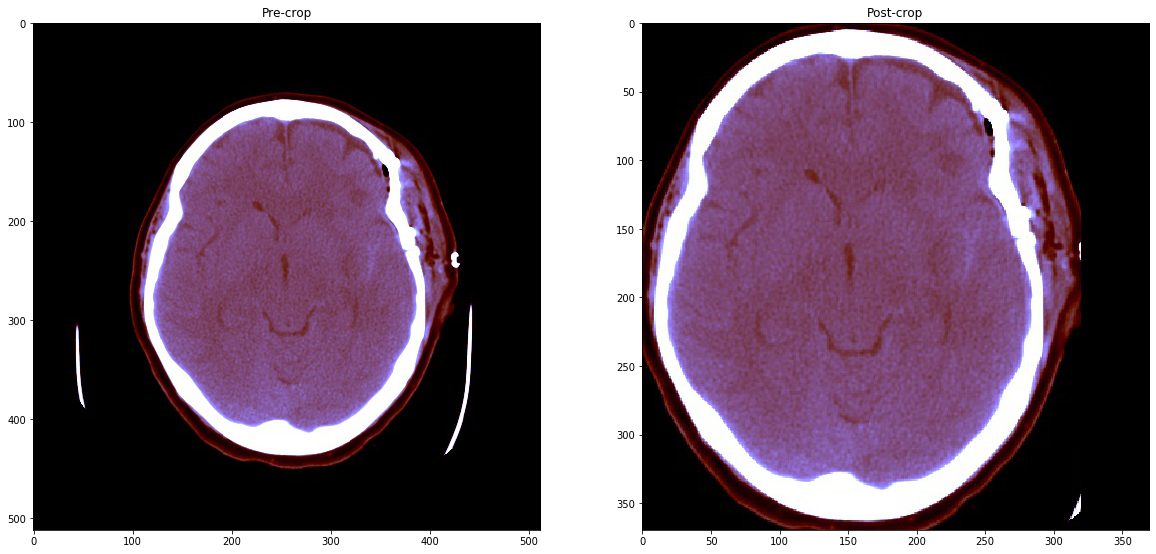

In [18]:
imageout2 = autocropmin(np_im, threshold=100)
im_ls = [im, imageout2]

titles = ['Pre-crop', 'Post-crop']
f, axarr = plt.subplots(1,2, figsize=(20, 10))
for i in range(2):
    axarr[i].imshow(im_ls[i], cmap='gray')
    axarr[i].set_title(titles[i])

#  Custom Dataset: IntracranialDataset Class

This custom dataset class performs the following:
- Appends the .jpg suffix to the image name
- Reads the image data into an array using OpenCV
- Crops the image using `autocrop` (if crop flag is set to true)
- Resizes the image to the specified size (408 in my case)
- Transforms the image according to the transforms given
- Adds labels to the output dataset

And returns a **dictionary** with the image array and the labels for that image (where `labels` flag is true)

In [6]:
class IntracranialDataset(Dataset):
    def __init__(self, df, path, labels, transform=None):
        self.path = path
        self.data = df
        self.transform = transform
        self.labels = labels
        self.crop = AUTOCROP

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.jpg')
        img = cv2.imread(img_name)    
        if self.crop:
            try:
                try:
                    img = autocrop(img, threshold=0, kernsel_size = image.shape[0]//15)
                except:
                    img = autocrop(img, threshold=0)  
            except:
                1  

        try:
            img = cv2.resize(img,(SIZE,SIZE))
        except Exception as e:
            print(str(e))
            
        if self.transform:       
            augmented = self.transform(image=img)
            img = augmented['image']   
        if self.labels:
            labels = torch.tensor(
                self.data.loc[idx, label_cols])
            return {'image': img, 'labels': labels}    
        else:      
            return {'image': img}

### Load Dataframes

In [7]:
train = pd.read_csv(os.path.join(path_data, 'darraghdog_train.csv.gz'))
test = pd.read_csv(os.path.join(path_data, 'darraghdog_test.csv.gz'))
test.Image = 'test_' + test.Image

logger.info('Trn shape {} {}'.format(*train.shape))
logger.info('Tst shape {} {}'.format(*test.shape))
logger.info('Processed img path : {}'.format(os.path.join(dir_train_img, '**.jpg')))

png = glob.glob(os.path.join(dir_train_img, '*.jpg'))
png = [os.path.basename(png)[:-4] for png in png]
png = [imgnmf.split('_', maxsplit=1)[1] for imgnmf in png]

logger.info('Count of pngs : {}'.format(len(png)))

train_imgs = set(train.Image.tolist())
png = [p for p in png if p in train_imgs]

logger.info('Number of images to train on {}'.format(len(png)))
png = np.array(png)
train = train.set_index('Image').loc[png].reset_index()
logger.info('Trn shape {} {}'.format(*train.shape))

train.Image = 'train_' + train.Image

2020-01-22 14:45:46,444 - Rsna-lb-408-fp16 - INFO - Load Dataframes
2020-01-22 14:45:46,980 - Rsna-lb-408-fp16 - INFO - Trn shape 752803 9
2020-01-22 14:45:46,981 - Rsna-lb-408-fp16 - INFO - Tst shape 121232 2
2020-01-22 14:45:46,982 - Rsna-lb-408-fp16 - INFO - Processed img path : data/rsna_darraghdog/darraghdog_proc/**.jpg
2020-01-22 14:45:49,435 - Rsna-lb-408-fp16 - INFO - Count of pngs : 874034
2020-01-22 14:45:49,754 - Rsna-lb-408-fp16 - INFO - Number of images to train on 752802
2020-01-22 14:45:50,815 - Rsna-lb-408-fp16 - INFO - Trn shape 752802 9


# Create Train/Validation set
The original 2nd place solution used 5-fold cross validation to create the validation set. It was split by PatientID. See the code here: https://github.com/darraghdog/rsna/blob/master/scripts/prepare_folds.py


## My dataset split
In this version I just wanted a dataset of about 100K images, so I created my own train/validation split with a 50/50 positive/negative split


- **Selected the positives for the train and val sets:**
    - Find all postive patients for each label ('label == 1')
    - Randomly sample the desired number of patients (each patient had an average of ~40 images) for the train set
    - 85% in the train set and 15% in the test set
    - Randomly sample the remaining 15% for the patients val set from the remainder
    - Select all images corresponding to these patients and add to the train and val set
    - Remove any overlaps between the train and val set from the val set. They have crept in between the train and val sets due to some patients having multiple different haemorrage types
    - Remove any negative images from both sets. These are added when all images from a patient are added. Because the images are a sequence often the beginning and ending images are negatives, thus when all images were selected some negatives crept in.
    
- **Selected the negatives for the train and val sets:**
    - Randomly select negative patients (don't have any == 1)
    - Split patients by 85/15 split
    - Select images from these patients and match the count in the positive set
    - Merge negatives dataframe with positives datadrame

### Create Positive Test set

In [58]:
# CREATE SMALLER SAMPLE SET FOR ITERATIONS
n = 30000
trn_frac = 0.85

trndf = train
print(len(trndf))
trn_pats_full = []
val_pats_full = []

avg_nimgs_per_pat = len(trndf) / len(trndf.PatientID.unique())

# ADD POSITIVES
for i,l in enumerate(label_cols):
    if i == 0:
        # Randomnly select (n/avg images per patient) unique patient IDs from the label group
        max_len = len(trndf.query(f'{l} == 1').PatientID.unique())
        pats = sample(list(trndf.query(f'{l} == 1').PatientID.unique()), min(max_len, round(n/avg_nimgs_per_pat)))
        trn_cnt = round(len(pats) * trn_frac)
        
        # Training patients
        trn_pats = sample(list(pats), trn_cnt)
        trn_fin_df = trndf[trndf['PatientID'].isin(trn_pats)].copy()

        # Val patients
        val_pats = [a for a in pats if a not in set(trn_pats)]
        val_fin_df = trndf[trndf['PatientID'].isin(val_pats)].copy()
        
        trn_pats_full.append(trn_pats)
        val_pats_full.append(val_pats)
        
    # Randomnly select (n/avg images per patient) unique patient IDs from the label group
    max_len = len(trndf.query(f'{l} == 1').PatientID.unique())
    pats = sample(list(trndf.query(f'{l} == 1').PatientID.unique()), min(max_len, round(n/avg_nimgs_per_pat)))
    trn_cnt = round(len(pats) * trn_frac)
    
    # Train patients
    trn_pats = sample(list(pats), trn_cnt)
    trn_fin_df = pd.concat([trn_fin_df, trndf[trndf['PatientID'].isin(trn_pats)].copy()])
    
    # Val patients
    val_pats = [a for a in pats if a not in set(trn_pats)]
    val_fin_df = pd.concat([val_fin_df, trndf[trndf['PatientID'].isin(val_pats)].copy()])

    trn_pats_full.append(trn_pats)
    val_pats_full.append(val_pats)


# REMOVE ANY PATIENT_ID OVERLAPS
trn_flat_list = [item for sublist in trn_pats_full for item in sublist]
val_flat_list = [item for sublist in val_pats_full for item in sublist]

print(f'len of Patient overlap: {len(set(trn_flat_list) & set(val_flat_list))}')

overlaps = set(trn_flat_list) & set(val_flat_list)
val_list = [val for val in val_flat_list if val not in overlaps]

val_fin_df = val_fin_df[val_fin_df.PatientID.isin(val_list)]

# Remove overlapping samples

# Filter the Negative images from the Postive Patients
# Positive patients will have negative images, lets drop those images 
# to maximise the positive count
trn_pos_imgs = trn_fin_df.query('any == 1').Image.values
trn_fin_df = trn_fin_df[trn_fin_df.Image.isin(trn_pos_imgs)]
trn_fin_df.drop_duplicates(inplace=True)

val_pos_imgs = val_fin_df.query('any == 1').Image.values
val_fin_df = val_fin_df[val_fin_df.Image.isin(val_pos_imgs)]
val_fin_df.drop_duplicates(inplace=True)

# Check for any overlaps
overlaps = bool(set(trn_fin_df.PatientID.unique()) & set(val_fin_df.PatientID.unique()))

print(f'Are there PatientID overlaps : {overlaps}')
    
print(f'There are {len(trn_fin_df.query("any == 1"))} training positives')
print(f'There are {len(val_fin_df.query("any == 1"))} validation positives')
print(f'There are {len(trn_fin_df.query("any == 0"))} training negatives')
print(f'There are {len(val_fin_df.query("any == 0"))} validation negatives')
print()

# Positive label distribution
trn_dist = round((trn_fin_df[label_cols].sum() / trn_fin_df[label_cols].values.sum()), 3)
val_dist = round((val_fin_df[label_cols].sum() / val_fin_df[label_cols].values.sum()), 3)

print('Positive Label Distribution - Training:')
print(trn_dist)
print()
print('Positive Label Distribution - Validation:')
print(val_dist)

print(len(trndf))

752802
len of Patient overlap: 234
Are there PatientID overlaps : False
There are 46198 training positives
There are 5978 validation positives
There are 0 training negatives
There are 0 validation negatives

Positive Label Distribution - Training:
epidural            0.027
intraparenchymal    0.136
intraventricular    0.106
subarachnoid        0.150
subdural            0.172
any                 0.408
dtype: float64

Positive Label Distribution - Validation:
epidural            0.005
intraparenchymal    0.151
intraventricular    0.115
subarachnoid        0.139
subdural            0.183
any                 0.406
dtype: float64
752802


### Add Negatives

In [59]:
n = 25000

# Add NEGATIVES
# Identify all Patients with at least 1 positive sample    
pos_pats = list(trndf.query('any == 1').PatientID.unique())

# randomly sample from negative patients (patients without any == 1)
#negs_pats = sample(list(trndf[~trndf['PatientID'].isin(pos)].PatientID.unique()), round(n*6/avg_nimgs_per_pat))
neg_pats = trndf[~trndf['PatientID'].isin(pos_pats)].PatientID.unique()

# randomly sample trn_frac of selected neg patients, splitting by Patient
trn_cnt = round(len(neg_pats) * trn_frac) - 1
trn_neg_pats = sample(list(neg_pats), trn_cnt)
val_neg_pats = val_pats = [a for a in list(neg_pats) if a not in set(trn_neg_pats)]

# Get negatives data
# Match length of positives
neg_trn_df = trndf[trndf['PatientID'].isin(trn_neg_pats)].sample(len(trn_fin_df))
neg_val_df = trndf[trndf['PatientID'].isin(val_neg_pats)].sample(len(val_fin_df))

# Concat trn and val negs
trn_fin_df = pd.concat([trn_fin_df, neg_trn_df])
val_fin_df = pd.concat([val_fin_df, neg_val_df])

trn_fin_df.reset_index(drop=True, inplace=True)
val_fin_df.reset_index(drop=True, inplace=True)

print(f'There are {len(trn_fin_df.query("any == 1"))} positives in the trn set')
print(f'There are {len(trn_fin_df.query("any == 0"))} negatives in the trn set')
print(f'There are {len(val_fin_df.query("any == 1"))} positives in the val set')
print(f'There are {len(val_fin_df.query("any == 0"))} negatives in the val set')

# Check for duplicates

overlaps = bool(set(trn_fin_df.PatientID.unique()) & set(val_fin_df.PatientID.unique()))
print(f'Are there PatientID overlaps? - {overlaps}')

############################################
# NOT USING FOLDS FOR NOW
# get fold
# valdf = train[train['fold']==fold].reset_index(drop=True)
# trndf = train[train['fold']!=fold].reset_index(drop=True)
############################################

trn_fin_df.to_csv('trndf_imgclassifier.csv')
val_fin_df.to_csv('valdf_imgclassifier.csv')
test.to_csv('test_imgclassifier.csv')

There are 46198 positives in the trn set
There are 46198 negatives in the trn set
There are 5978 positives in the val set
There are 5978 negatives in the val set
Are there PatientID overlaps? - False


In [60]:
trndf = trn_fin_df
valdf = val_fin_df

#To make things easy, if the val dataset is empty, we will sanity check it on some records
if valdf.shape[0]==0:
    valdf = trndf.head(1000).copy()
logger.info('Trn shape {} {}'.format(*trndf.shape))
logger.info('Val shape {} {}'.format(*valdf.shape))
logger.info('Test shape {} {}'.format(*test.shape))

2020-01-22 15:23:07,781 - Rsna-lb-408-fp16 - INFO - Trn shape 92396 9
2020-01-22 15:23:07,782 - Rsna-lb-408-fp16 - INFO - Val shape 11956 9
2020-01-22 15:23:07,783 - Rsna-lb-408-fp16 - INFO - Test shape 121232 2


### Create Dataloaders

In [62]:
# Data loaders
LIMIT = 100
mean_img = [0.22363983, 0.18190407, 0.2523437 ]
std_img = [0.32451536, 0.2956294,  0.31335256]

transform_train = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                         rotate_limit=20, p=0.3, border_mode = cv2.BORDER_REPLICATE),
    Transpose(p=0.5),
    Normalize(mean=mean_img, std=std_img, max_pixel_value=255.0, p=1.0),
    ToTensor()
])

HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0
TRANSPOSEVAL = 1.0 if TRANSPOSE == 'P' else 0.0
transform_test= Compose([
    HorizontalFlip(p=HFLIPVAL),
    Transpose(p=TRANSPOSEVAL),
    Normalize(mean=mean_img, std=std_img, max_pixel_value=255.0, p=1.0),
    ToTensor()
])

trndataset = IntracranialDataset(trndf, path=dir_train_img, transform=transform_train, labels=True)
valdataset = IntracranialDataset(valdf, path=dir_train_img, transform=transform_test, labels=True)
tstdataset = IntracranialDataset(test, path=dir_test_img, transform=transform_test, labels=False)

# Smaller dataset for rapid testing
# trndataset = IntracranialDataset(trndf.iloc[:LIMIT,], path=dir_train_img, transform=transform_train, labels=True)
# valdataset = IntracranialDataset(valdf.iloc[:LIMIT,], path=dir_train_img, transform=transform_test, labels=True)
# tstdataset = IntracranialDataset(test.iloc[:LIMIT,], path=dir_test_img, transform=transform_test, labels=False)

num_workers = 0
batch_size = 18
trnloader = DataLoader(trndataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(valdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)
tstloader = DataLoader(tstdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)

### Training Prep Model

Define a function to calculate the validation loss

In [65]:
def get_val_loss(epoch, loader):
    val_loss=0
    model.eval()
    
    for step, batch in enumerate(loader):
        if step%50==0:
            logger.info('Val step {} of {}'.format(step, len(loader)))
            
        inputs = batch["image"]
        inputs = inputs.to(device, dtype=torch.float)  
        
        logits = model(inputs)
        
        labels = batch["labels"]
        labels = labels.to(device, dtype=torch.float)
        
        loss = criterion(logits, labels)
        val_loss += loss.item()

    epoch_loss = val_loss / len(loader)
    logger.info(f'Validation loss for Epoch {epoch} is {epoch_loss}')
    
    return epoch_loss 

### Loss Function - BCEWithLogitsLoss

In [66]:
criterion = torch.nn.BCEWithLogitsLoss()
def criterion(data, targets, criterion = torch.nn.BCEWithLogitsLoss()):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    loss_all = criterion(data, targets)
    loss_any = criterion(data[:,-1:], targets[:,-1:])
    return (loss_all*6 + loss_any*1)/7

### This Identity class will be used to extract the final fully connected layer weights from the model

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

### Load resnext101_32x8d_wsl

In [67]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
print('Loaded model')
model.fc = torch.nn.Linear(2048, n_classes)
print('Added fc')
model.to(device)
print('Model moved to GPU')

plist = [{'params': model.parameters(), 'lr': lr}]
optimizer = optim.Adam(plist, lr=lr)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
print('amp initialized')
model = torch.nn.DataParallel(model, device_ids=list(range(n_gpu)))

Using cache found in data/rsna_darraghdog/mount/hub/facebookresearch_WSL-Images_master


Loaded model
Added fc
Model moved to GPU
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
amp initialized


### Run Training

In [68]:
for epoch in range(int(n_epochs)):
    logger.info('Epoch {}/{}'.format(epoch, int(n_epochs) - 1))
    logger.info('-' * 10)
    
    for param in model.parameters():
        param.requires_grad = True
    model.train()    
    tr_loss = 0
    
    for step, batch in enumerate(trnloader):
        if step == 0: print('STARTING')
        if step%100==0:
            logger.info('Train step {} of {}'.format(step, len(trnloader)))
        inputs = batch["image"]
        labels = batch["labels"]
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        tr_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        del inputs, labels, outputs
    epoch_loss = tr_loss / len(trnloader)
    logger.info('Training Loss: {:.4f}'.format(epoch_loss))
    for param in model.parameters():
        param.requires_grad = False

    # get Validation loss
    logger.info('Prep val score...')
    val_loss = get_val_loss(epoch, valloader)

    output_model_file = os.path.join(WORK_DIR, 'model_{}_epoch{}_fold{}.bin'.format(WTSIZE, epoch, fold))
    torch.save(model.state_dict(), output_model_file)
    
    model.eval()
    logger.info(model.parameters())

2020-01-22 15:24:35,020 - Rsna-lb-408-fp16 - INFO - Epoch 0/4
2020-01-22 15:24:35,021 - Rsna-lb-408-fp16 - INFO - ----------
2020-01-22 15:24:35,199 - Rsna-lb-408-fp16 - INFO - Train step 0 of 5134


STARTING


2020-01-22 15:28:38,351 - Rsna-lb-408-fp16 - INFO - Train step 100 of 5134
2020-01-22 15:32:41,358 - Rsna-lb-408-fp16 - INFO - Train step 200 of 5134


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


2020-01-22 15:36:44,049 - Rsna-lb-408-fp16 - INFO - Train step 300 of 5134
2020-01-22 15:40:46,886 - Rsna-lb-408-fp16 - INFO - Train step 400 of 5134
2020-01-22 15:44:49,809 - Rsna-lb-408-fp16 - INFO - Train step 500 of 5134
2020-01-22 15:48:52,517 - Rsna-lb-408-fp16 - INFO - Train step 600 of 5134
2020-01-22 15:52:55,504 - Rsna-lb-408-fp16 - INFO - Train step 700 of 5134
2020-01-22 15:56:58,467 - Rsna-lb-408-fp16 - INFO - Train step 800 of 5134
2020-01-22 16:01:01,683 - Rsna-lb-408-fp16 - INFO - Train step 900 of 5134
2020-01-22 16:05:04,749 - Rsna-lb-408-fp16 - INFO - Train step 1000 of 5134
2020-01-22 16:09:07,941 - Rsna-lb-408-fp16 - INFO - Train step 1100 of 5134
2020-01-22 16:13:10,832 - Rsna-lb-408-fp16 - INFO - Train step 1200 of 5134
2020-01-22 16:17:14,041 - Rsna-lb-408-fp16 - INFO - Train step 1300 of 5134
2020-01-22 16:21:17,123 - Rsna-lb-408-fp16 - INFO - Train step 1400 of 5134
2020-01-22 16:25:20,161 - Rsna-lb-408-fp16 - INFO - Train step 1500 of 5134
2020-01-22 16:29:23

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-22 18:22:47,307 - Rsna-lb-408-fp16 - INFO - Train step 4400 of 5134
2020-01-22 18:26:50,525 - Rsna-lb-408-fp16 - INFO - Train step 4500 of 5134
2020-01-22 18:30:53,637 - Rsna-lb-408-fp16 - INFO - Train step 4600 of 5134
2020-01-22 18:34:56,800 - Rsna-lb-408-fp16 - INFO - Train step 4700 of 5134
2020-01-22 18:38:59,817 - Rsna-lb-408-fp16 - INFO - Train step 4800 of 5134
2020-01-22 18:43:02,915 - Rsna-lb-408-fp16 - INFO - Train step 4900 of 5134
2020-01-22 18:47:05,958 - Rsna-lb-408-fp16 - INFO - Train step 5000 of 5134
2020-01-22 18:51:09,165 - Rsna-lb-408-fp16 - INFO - Train step 5100 of 5134
2020-01-22 18:52:29,663 - Rsna-lb-408-fp16 - INFO - Training Loss: 0.2042
2020-01-22 18:52:29,665 - Rsna-lb-408-fp16 - INFO - Prep val score...
2020-01-22 18:52:30,310 - Rsna-lb-408-fp16 - INFO - Val step 0 of 167
2020-01-22 18:56:08,638 - Rsna-lb-408-fp16 - INFO - Val step 50 of 167
2020-01-22 18:59:46,583 - Rsna-lb-408-fp16 - INFO - Val step 100 of 167
2020-01-22 19:03:23,993 - Rsna-lb-4

STARTING


2020-01-22 19:08:35,438 - Rsna-lb-408-fp16 - INFO - Train step 100 of 5134
2020-01-22 19:12:37,067 - Rsna-lb-408-fp16 - INFO - Train step 200 of 5134
2020-01-22 19:16:38,745 - Rsna-lb-408-fp16 - INFO - Train step 300 of 5134
2020-01-22 19:20:40,304 - Rsna-lb-408-fp16 - INFO - Train step 400 of 5134
2020-01-22 19:24:41,992 - Rsna-lb-408-fp16 - INFO - Train step 500 of 5134
2020-01-22 19:28:43,539 - Rsna-lb-408-fp16 - INFO - Train step 600 of 5134
2020-01-22 19:32:45,130 - Rsna-lb-408-fp16 - INFO - Train step 700 of 5134
2020-01-22 19:36:46,728 - Rsna-lb-408-fp16 - INFO - Train step 800 of 5134
2020-01-22 19:40:48,319 - Rsna-lb-408-fp16 - INFO - Train step 900 of 5134
2020-01-22 19:44:49,978 - Rsna-lb-408-fp16 - INFO - Train step 1000 of 5134
2020-01-22 19:48:51,729 - Rsna-lb-408-fp16 - INFO - Train step 1100 of 5134
2020-01-22 19:52:53,529 - Rsna-lb-408-fp16 - INFO - Train step 1200 of 5134
2020-01-22 19:56:55,139 - Rsna-lb-408-fp16 - INFO - Train step 1300 of 5134


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-22 20:00:56,810 - Rsna-lb-408-fp16 - INFO - Train step 1400 of 5134
2020-01-22 20:04:58,538 - Rsna-lb-408-fp16 - INFO - Train step 1500 of 5134
2020-01-22 20:09:00,084 - Rsna-lb-408-fp16 - INFO - Train step 1600 of 5134
2020-01-22 20:13:01,682 - Rsna-lb-408-fp16 - INFO - Train step 1700 of 5134
2020-01-22 20:17:03,289 - Rsna-lb-408-fp16 - INFO - Train step 1800 of 5134
2020-01-22 20:21:04,899 - Rsna-lb-408-fp16 - INFO - Train step 1900 of 5134
2020-01-22 20:25:06,481 - Rsna-lb-408-fp16 - INFO - Train step 2000 of 5134
2020-01-22 20:29:08,212 - Rsna-lb-408-fp16 - INFO - Train step 2100 of 5134
2020-01-22 20:33:09,934 - Rsna-lb-408-fp16 - INFO - Train step 2200 of 5134
2020-01-22 20:37:11,558 - Rsna-lb-408-fp16 - INFO - Train step 2300 of 5134
2020-01-22 20:41:13,256 - Rsna-lb-408-fp16 - INFO - Train step 2400 of 5134
2020-01-22 20:45:14,881 - Rsna-lb-408-fp16 - INFO - Train step 2500 of 5134
2020-01-22 20:49:16,521 - Rsna-lb-408-fp16 - INFO - Train step 2600 of 5134
2020-01-22 2

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-22 22:05:47,856 - Rsna-lb-408-fp16 - INFO - Train step 4500 of 5134
2020-01-22 22:09:49,476 - Rsna-lb-408-fp16 - INFO - Train step 4600 of 5134
2020-01-22 22:13:51,067 - Rsna-lb-408-fp16 - INFO - Train step 4700 of 5134
2020-01-22 22:17:52,737 - Rsna-lb-408-fp16 - INFO - Train step 4800 of 5134
2020-01-22 22:21:54,469 - Rsna-lb-408-fp16 - INFO - Train step 4900 of 5134
2020-01-22 22:25:56,077 - Rsna-lb-408-fp16 - INFO - Train step 5000 of 5134
2020-01-22 22:29:57,778 - Rsna-lb-408-fp16 - INFO - Train step 5100 of 5134
2020-01-22 22:31:17,722 - Rsna-lb-408-fp16 - INFO - Training Loss: 0.1566
2020-01-22 22:31:17,724 - Rsna-lb-408-fp16 - INFO - Prep val score...
2020-01-22 22:31:18,349 - Rsna-lb-408-fp16 - INFO - Val step 0 of 167
2020-01-22 22:34:56,029 - Rsna-lb-408-fp16 - INFO - Val step 50 of 167
2020-01-22 22:38:33,510 - Rsna-lb-408-fp16 - INFO - Val step 100 of 167
2020-01-22 22:42:10,746 - Rsna-lb-408-fp16 - INFO - Val step 150 of 167
2020-01-22 22:43:19,882 - Rsna-lb-408-f

STARTING


2020-01-22 22:51:23,496 - Rsna-lb-408-fp16 - INFO - Train step 200 of 5134
2020-01-22 22:55:25,056 - Rsna-lb-408-fp16 - INFO - Train step 300 of 5134
2020-01-22 22:59:26,659 - Rsna-lb-408-fp16 - INFO - Train step 400 of 5134
2020-01-22 23:03:28,415 - Rsna-lb-408-fp16 - INFO - Train step 500 of 5134
2020-01-22 23:07:30,102 - Rsna-lb-408-fp16 - INFO - Train step 600 of 5134
2020-01-22 23:11:31,844 - Rsna-lb-408-fp16 - INFO - Train step 700 of 5134
2020-01-22 23:15:33,599 - Rsna-lb-408-fp16 - INFO - Train step 800 of 5134
2020-01-22 23:19:35,240 - Rsna-lb-408-fp16 - INFO - Train step 900 of 5134
2020-01-22 23:23:36,832 - Rsna-lb-408-fp16 - INFO - Train step 1000 of 5134
2020-01-22 23:27:38,387 - Rsna-lb-408-fp16 - INFO - Train step 1100 of 5134
2020-01-22 23:31:40,009 - Rsna-lb-408-fp16 - INFO - Train step 1200 of 5134
2020-01-22 23:35:41,609 - Rsna-lb-408-fp16 - INFO - Train step 1300 of 5134
2020-01-22 23:39:43,288 - Rsna-lb-408-fp16 - INFO - Train step 1400 of 5134
2020-01-22 23:43:44,

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-22 23:51:48,177 - Rsna-lb-408-fp16 - INFO - Train step 1700 of 5134
2020-01-22 23:55:49,864 - Rsna-lb-408-fp16 - INFO - Train step 1800 of 5134
2020-01-22 23:59:51,703 - Rsna-lb-408-fp16 - INFO - Train step 1900 of 5134
2020-01-23 00:03:53,497 - Rsna-lb-408-fp16 - INFO - Train step 2000 of 5134
2020-01-23 00:07:55,088 - Rsna-lb-408-fp16 - INFO - Train step 2100 of 5134
2020-01-23 00:11:56,672 - Rsna-lb-408-fp16 - INFO - Train step 2200 of 5134
2020-01-23 00:15:58,270 - Rsna-lb-408-fp16 - INFO - Train step 2300 of 5134
2020-01-23 00:19:59,956 - Rsna-lb-408-fp16 - INFO - Train step 2400 of 5134
2020-01-23 00:24:01,510 - Rsna-lb-408-fp16 - INFO - Train step 2500 of 5134
2020-01-23 00:28:03,220 - Rsna-lb-408-fp16 - INFO - Train step 2600 of 5134
2020-01-23 00:32:04,873 - Rsna-lb-408-fp16 - INFO - Train step 2700 of 5134
2020-01-23 00:36:06,609 - Rsna-lb-408-fp16 - INFO - Train step 2800 of 5134
2020-01-23 00:40:08,182 - Rsna-lb-408-fp16 - INFO - Train step 2900 of 5134
2020-01-23 0

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-23 02:10:05,140 - Rsna-lb-408-fp16 - INFO - Val step 0 of 167
2020-01-23 02:13:43,095 - Rsna-lb-408-fp16 - INFO - Val step 50 of 167
2020-01-23 02:17:21,026 - Rsna-lb-408-fp16 - INFO - Val step 100 of 167
2020-01-23 02:20:58,420 - Rsna-lb-408-fp16 - INFO - Val step 150 of 167
2020-01-23 02:22:07,622 - Rsna-lb-408-fp16 - INFO - Validation loss for Epoch 2 is 0.16204971286975695
2020-01-23 02:22:07,975 - Rsna-lb-408-fp16 - INFO - <generator object Module.parameters at 0x7fb63196d1d0>
2020-01-23 02:22:07,976 - Rsna-lb-408-fp16 - INFO - Epoch 3/4
2020-01-23 02:22:07,977 - Rsna-lb-408-fp16 - INFO - ----------
2020-01-23 02:22:08,151 - Rsna-lb-408-fp16 - INFO - Train step 0 of 5134


STARTING


2020-01-23 02:26:09,731 - Rsna-lb-408-fp16 - INFO - Train step 100 of 5134
2020-01-23 02:30:11,539 - Rsna-lb-408-fp16 - INFO - Train step 200 of 5134
2020-01-23 02:34:13,164 - Rsna-lb-408-fp16 - INFO - Train step 300 of 5134
2020-01-23 02:38:14,890 - Rsna-lb-408-fp16 - INFO - Train step 400 of 5134
2020-01-23 02:42:16,548 - Rsna-lb-408-fp16 - INFO - Train step 500 of 5134
2020-01-23 02:46:18,173 - Rsna-lb-408-fp16 - INFO - Train step 600 of 5134
2020-01-23 02:50:19,766 - Rsna-lb-408-fp16 - INFO - Train step 700 of 5134
2020-01-23 02:54:21,396 - Rsna-lb-408-fp16 - INFO - Train step 800 of 5134
2020-01-23 02:58:23,087 - Rsna-lb-408-fp16 - INFO - Train step 900 of 5134
2020-01-23 03:02:24,672 - Rsna-lb-408-fp16 - INFO - Train step 1000 of 5134
2020-01-23 03:06:26,363 - Rsna-lb-408-fp16 - INFO - Train step 1100 of 5134
2020-01-23 03:10:27,942 - Rsna-lb-408-fp16 - INFO - Train step 1200 of 5134
2020-01-23 03:14:29,626 - Rsna-lb-408-fp16 - INFO - Train step 1300 of 5134
2020-01-23 03:18:31,1

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


2020-01-23 05:07:15,372 - Rsna-lb-408-fp16 - INFO - Train step 4100 of 5134
2020-01-23 05:11:16,932 - Rsna-lb-408-fp16 - INFO - Train step 4200 of 5134
2020-01-23 05:15:18,532 - Rsna-lb-408-fp16 - INFO - Train step 4300 of 5134
2020-01-23 05:19:20,093 - Rsna-lb-408-fp16 - INFO - Train step 4400 of 5134
2020-01-23 05:23:21,675 - Rsna-lb-408-fp16 - INFO - Train step 4500 of 5134
2020-01-23 05:27:23,307 - Rsna-lb-408-fp16 - INFO - Train step 4600 of 5134
2020-01-23 05:31:24,871 - Rsna-lb-408-fp16 - INFO - Train step 4700 of 5134
2020-01-23 05:35:26,600 - Rsna-lb-408-fp16 - INFO - Train step 4800 of 5134
2020-01-23 05:39:28,376 - Rsna-lb-408-fp16 - INFO - Train step 4900 of 5134
2020-01-23 05:43:30,273 - Rsna-lb-408-fp16 - INFO - Train step 5000 of 5134
2020-01-23 05:47:32,028 - Rsna-lb-408-fp16 - INFO - Train step 5100 of 5134
2020-01-23 05:48:52,026 - Rsna-lb-408-fp16 - INFO - Training Loss: 0.1263
2020-01-23 05:48:52,028 - Rsna-lb-408-fp16 - INFO - Prep val score...
2020-01-23 05:48:52,

STARTING


2020-01-23 06:04:57,363 - Rsna-lb-408-fp16 - INFO - Train step 100 of 5134
2020-01-23 06:08:59,020 - Rsna-lb-408-fp16 - INFO - Train step 200 of 5134
2020-01-23 06:13:00,992 - Rsna-lb-408-fp16 - INFO - Train step 300 of 5134
2020-01-23 06:17:02,821 - Rsna-lb-408-fp16 - INFO - Train step 400 of 5134
2020-01-23 06:21:04,702 - Rsna-lb-408-fp16 - INFO - Train step 500 of 5134
2020-01-23 06:25:06,476 - Rsna-lb-408-fp16 - INFO - Train step 600 of 5134
2020-01-23 06:29:08,321 - Rsna-lb-408-fp16 - INFO - Train step 700 of 5134
2020-01-23 06:33:10,093 - Rsna-lb-408-fp16 - INFO - Train step 800 of 5134
2020-01-23 06:37:11,844 - Rsna-lb-408-fp16 - INFO - Train step 900 of 5134
2020-01-23 06:41:13,596 - Rsna-lb-408-fp16 - INFO - Train step 1000 of 5134


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


2020-01-23 06:45:15,228 - Rsna-lb-408-fp16 - INFO - Train step 1100 of 5134
2020-01-23 06:49:16,911 - Rsna-lb-408-fp16 - INFO - Train step 1200 of 5134
2020-01-23 06:53:18,554 - Rsna-lb-408-fp16 - INFO - Train step 1300 of 5134
2020-01-23 06:57:20,210 - Rsna-lb-408-fp16 - INFO - Train step 1400 of 5134
2020-01-23 07:01:22,017 - Rsna-lb-408-fp16 - INFO - Train step 1500 of 5134
2020-01-23 07:05:23,731 - Rsna-lb-408-fp16 - INFO - Train step 1600 of 5134
2020-01-23 07:09:25,516 - Rsna-lb-408-fp16 - INFO - Train step 1700 of 5134
2020-01-23 07:13:27,205 - Rsna-lb-408-fp16 - INFO - Train step 1800 of 5134
2020-01-23 07:17:28,986 - Rsna-lb-408-fp16 - INFO - Train step 1900 of 5134
2020-01-23 07:21:30,693 - Rsna-lb-408-fp16 - INFO - Train step 2000 of 5134
2020-01-23 07:25:32,392 - Rsna-lb-408-fp16 - INFO - Train step 2100 of 5134
2020-01-23 07:29:34,091 - Rsna-lb-408-fp16 - INFO - Train step 2200 of 5134
2020-01-23 07:33:35,784 - Rsna-lb-408-fp16 - INFO - Train step 2300 of 5134
2020-01-23 0

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-23 07:41:39,272 - Rsna-lb-408-fp16 - INFO - Train step 2500 of 5134
2020-01-23 07:45:41,119 - Rsna-lb-408-fp16 - INFO - Train step 2600 of 5134
2020-01-23 07:49:42,843 - Rsna-lb-408-fp16 - INFO - Train step 2700 of 5134
2020-01-23 07:53:44,643 - Rsna-lb-408-fp16 - INFO - Train step 2800 of 5134
2020-01-23 07:57:46,324 - Rsna-lb-408-fp16 - INFO - Train step 2900 of 5134
2020-01-23 08:01:48,059 - Rsna-lb-408-fp16 - INFO - Train step 3000 of 5134
2020-01-23 08:05:49,733 - Rsna-lb-408-fp16 - INFO - Train step 3100 of 5134
2020-01-23 08:09:51,360 - Rsna-lb-408-fp16 - INFO - Train step 3200 of 5134
2020-01-23 08:13:53,051 - Rsna-lb-408-fp16 - INFO - Train step 3300 of 5134
2020-01-23 08:17:54,787 - Rsna-lb-408-fp16 - INFO - Train step 3400 of 5134
2020-01-23 08:21:56,555 - Rsna-lb-408-fp16 - INFO - Train step 3500 of 5134
2020-01-23 08:25:58,198 - Rsna-lb-408-fp16 - INFO - Train step 3600 of 5134
2020-01-23 08:29:59,942 - Rsna-lb-408-fp16 - INFO - Train step 3700 of 5134
2020-01-23 0

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


2020-01-23 09:27:44,423 - Rsna-lb-408-fp16 - INFO - Val step 0 of 167
2020-01-23 09:31:22,455 - Rsna-lb-408-fp16 - INFO - Val step 50 of 167
2020-01-23 09:35:00,371 - Rsna-lb-408-fp16 - INFO - Val step 100 of 167
2020-01-23 09:38:38,049 - Rsna-lb-408-fp16 - INFO - Val step 150 of 167
2020-01-23 09:39:47,309 - Rsna-lb-408-fp16 - INFO - Validation loss for Epoch 4 is 0.16400429353809465
2020-01-23 09:39:47,662 - Rsna-lb-408-fp16 - INFO - <generator object Module.parameters at 0x7fb7043fd250>


# Extract embeddings

The code below will run inference on all the images from your train, validation and test sets, each time extracting the weights from the final fully connected layer a rank 1 tensor of size 2048 and saving them to a file.

### Loading already trained embeddings

**Stage 1 Embeddings**

Stage 1 embeddings and dataloaders can be downloaded here:

- `gdown https://drive.google.com/uc?id=13hqPFdCjoMxtAwF863J3Dk33TcBN_wie -O resnext101v12fold1.tar.gz`

**Stage 2 Embeddings**

The winners also enabled us to download the 2nd Place Stage 2 **test set** embeddings from their trained Resnext101 model. We'll use these in the next section 

- `wget gdown https://drive.google.com/uc?id=1YxCJ0mWIYXfYLN15DPpQ6OLSt4Y54Hp0 -O stg2tst.tar.gz`

The are saved in a google drive as described here https://github.com/darraghdog/rsna : [Google Drive link](https://drive.google.com/uc?id=1YxCJ0mWIYXfYLN15DPpQ6OLSt4Y54Hp0)

Remember to install the `gdown` package (`pip install gdown`) before trying to install this file to be able to download large files from Google Drive. Alternaively, following the [2-step instructions from StackOverflow here](https://unix.stackexchange.com/a/332277) will get it to download for you too

In [71]:
# Extract original and flipped image embeddings
logmsg = f'Rsna-lb-{SIZE}-fp16' 
start = 0 
epochs = 10
fold = f'{FOLD}'
lr = 0.00002 
batchsize = 18
workpath = f'scripts/{WDIR}'
stage2 = 'T'
hflip = 'HFLIP'
transpose = 'F'

weightsname = f'weights/model_{SIZE}_resnext101{FOLD}.bin'


SEED = int(options.seed)
#SIZE = int(options.size)
WTSIZE=int(options.wtsize) if int(options.wtsize) != 999 else SIZE
EPOCHS = epochs #int(options.epochs)
n_epochs = epochs #EPOCHS 
START = start #int(options.start)
lr=float(lr)
batch_size = int(batchsize)
WEIGHTS_NAME = weightsname
INFER= 'EMB'  #options.infer
HFLIP = 'HFLIP'   #'T' if options.hflip=='T' else ''
TRANSPOSE = 'F'  #'P' if options.transpose=='T' else ''
STAGE2=options.stage2=='T'

### Begin Extraction

In [75]:
for epoch in range(int(n_epochs)):
    logger.info('Epoch {}/{}'.format(epoch, int(n_epochs) - 1))
    logger.info('-' * 10)

    del model

    model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    model.fc = torch.nn.Linear(2048, n_classes)
    device = torch.device("cuda:{}".format(n_gpu-1))
    model.to(device)
    model = torch.nn.DataParallel(model, device_ids=list(range(n_gpu)[::-1]), output_device=device)
    for param in model.parameters():
        param.requires_grad = False
    input_model_file = os.path.join(WORK_DIR, 'model_{}_epoch{}_fold{}.bin'.format(WTSIZE, epoch, fold))
    model.load_state_dict(torch.load(input_model_file))
    model.to(device)
    
    model.eval()
    logger.info(model.parameters())
    
    logger.info('Output embeddings epoch {}'.format(epoch))
    logger.info('Train shape {} {}'.format(*trndf.shape))
    logger.info('Valid shape {} {}'.format(*valdf.shape))
    logger.info('Test  shape {} {}'.format(*test.shape)) 

    trndataset = IntracranialDataset(trndf, path=dir_train_img, transform=transform_test, labels=False)
    valdataset = IntracranialDataset(valdf, path=dir_train_img, transform=transform_test, labels=False)
    tstdataset = IntracranialDataset(test, path=dir_test_img, transform=transform_test, labels=False)

    trnloader = DataLoader(trndataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)
    valloader = DataLoader(valdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)
    tstloader = DataLoader(tstdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)

    # Extract embedding layer
    model.module.fc = Identity()
    model.eval()
    DATASETS = ['tst', 'val', 'trn'] 
    LOADERS = [tstloader, valloader, trnloader]
    for typ, loader in zip(DATASETS, LOADERS):
        ls = []
        for step, batch in enumerate(loader):
            if step%100==0:
                logger.info('Embedding {} step {} of {}'.format(typ, step, len(loader)))
            inputs = batch["image"]
            inputs = inputs.to(device, dtype=torch.float)
            out = model(inputs)
            ls.append(out.detach().cpu().numpy())
        outemb = np.concatenate(ls, 0).astype(np.float32)
        logger.info('Write embeddings : shape {} {}'.format(*outemb.shape))
        fembname =  'emb{}_{}_size{}_fold{}_ep{}'.format(HFLIP+TRANSPOSE, typ, SIZE, fold, epoch)
        logger.info('Embedding file name : {}'.format(fembname))
        np.savez_compressed(os.path.join(WORK_DIR, 'emb{}_{}_size{}_fold{}_ep{}'.format(HFLIP+TRANSPOSE, typ, SIZE, fold, epoch)), outemb)
        dumpobj(os.path.join(WORK_DIR, 'loader{}_{}_size{}_fold{}_ep{}'.format(HFLIP+TRANSPOSE, typ, SIZE, fold, epoch)), loader)
        gc.collect()

2020-01-24 10:04:18,970 - Rsna-lb-408-fp16 - INFO - Epoch 5/9
2020-01-24 10:04:18,972 - Rsna-lb-408-fp16 - INFO - ----------
Using cache found in data/rsna_darraghdog/mount/hub/facebookresearch_WSL-Images_master
2020-01-24 10:04:20,283 - Rsna-lb-408-fp16 - INFO - <generator object Module.parameters at 0x7fb631957150>
2020-01-24 10:04:20,284 - Rsna-lb-408-fp16 - INFO - Output embeddings epoch 5
2020-01-24 10:04:20,284 - Rsna-lb-408-fp16 - INFO - Train shape 92396 9
2020-01-24 10:04:20,285 - Rsna-lb-408-fp16 - INFO - Valid shape 11956 9
2020-01-24 10:04:20,285 - Rsna-lb-408-fp16 - INFO - Test  shape 121232 2
2020-01-24 10:04:20,845 - Rsna-lb-408-fp16 - INFO - Embedding tst step 0 of 1684
2020-01-24 10:11:29,074 - Rsna-lb-408-fp16 - INFO - Embedding tst step 100 of 1684
2020-01-24 10:18:37,176 - Rsna-lb-408-fp16 - INFO - Embedding tst step 200 of 1684
2020-01-24 10:25:45,665 - Rsna-lb-408-fp16 - INFO - Embedding tst step 300 of 1684
2020-01-24 10:32:54,507 - Rsna-lb-408-fp16 - INFO - Embe

KeyboardInterrupt: 